In [252]:
# basic packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [253]:
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target,columns=['target'])

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [254]:
X.shape

(20640, 8)

In [255]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (common preprocessing step)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [256]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [257]:
# Convert data to PyTorch tensors (backend setup)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for batching
train_loader = DataLoader(TensorDataset(X_train_tensor,y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor,y_test_tensor), batch_size=64, shuffle=False)

In [258]:
# Create the model
class RegressionNN(nn.Module):
    def __init__(self, input_size=8):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1) # 1 output for house value prediction

        #self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
      # functional API
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [260]:
# Initialize the model, loss function, and optimizer
pytorch_model = RegressionNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

In [261]:
!pip install torchsummary

In [262]:
from torchsummary import summary
print("PyTorch Model Summary:")
summary(pytorch_model, input_size=(8,))

PyTorch Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,152
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 32]           2,080
            Linear-4                    [-1, 1]              33
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [263]:
def train_regression(train_loader, model, criterion, optimizer, num_epochs=40):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward() # backpropagation
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


train_regression(train_loader, pytorch_model, criterion, optimizer, num_epochs=40)

Epoch 1/40, Loss: 1.1107847408730855
Epoch 2/40, Loss: 0.422645375825638
Epoch 3/40, Loss: 0.3790915569709253
Epoch 4/40, Loss: 0.3655375875243845
Epoch 5/40, Loss: 0.34685330422118654
Epoch 6/40, Loss: 0.3354756755306739
Epoch 7/40, Loss: 0.33000961997250255
Epoch 8/40, Loss: 0.3153681112236755
Epoch 9/40, Loss: 0.3098303629157617
Epoch 10/40, Loss: 0.3034360319260479
Epoch 11/40, Loss: 0.29719149997068006
Epoch 12/40, Loss: 0.29477946835663893
Epoch 13/40, Loss: 0.2906342560584231
Epoch 14/40, Loss: 0.29065179512944334
Epoch 15/40, Loss: 0.29245401399080145
Epoch 16/40, Loss: 0.28790831528315247
Epoch 17/40, Loss: 0.28149777954054434
Epoch 18/40, Loss: 0.28147558631129965
Epoch 19/40, Loss: 0.278370016102874
Epoch 20/40, Loss: 0.2737439398386682
Epoch 21/40, Loss: 0.27608314303811204
Epoch 22/40, Loss: 0.2730555274170037
Epoch 23/40, Loss: 0.2744045842929866
Epoch 24/40, Loss: 0.27176815300255786
Epoch 25/40, Loss: 0.26821805247964786
Epoch 26/40, Loss: 0.2697240315204443
Epoch 27/40

In [264]:
def eval_regression(test_loader, model):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()
    return test_loss / len(test_loader)

test_loss = eval_regression(test_loader, pytorch_model)
print(f"Test Loss: {test_loss}")

Test Loss: 0.27853157291045555


In [265]:
# Get a batch of data from the training set in PyTorch
data_iter = iter(train_loader)
X_batch, y_batch = next(data_iter)


# Forward pass through the model to get predictions (continuous values for regression)
outputs = pytorch_model(X_batch)

# Print the predicted values and actual values for the batch (regression outputs)
print(f'Predicted values (PyTorch): {outputs.squeeze().detach().numpy()}')  # Squeeze and convert to numpy for readability
print(f'Actual values (PyTorch): {y_batch.squeeze().detach().numpy()}')  # Squeeze and convert to numpy for readability

# Calculate the Mean Squared Error (MSE) for this batch
mse_loss = nn.MSELoss()
loss = mse_loss(outputs, y_batch)
print(f'Mean Squared Error for this batch (PyTorch): {loss.item()}')

Predicted values (PyTorch): [2.0633037  1.2218177  1.4181823  1.8121322  1.7787421  1.8127596
 1.3465741  1.440633   1.5160692  2.571383   3.3223531  1.5161772
 2.8522084  2.397526   3.237335   3.4010942  1.0253006  1.0302216
 1.3387809  3.3312833  3.121824   1.1255155  1.7496297  1.463745
 2.4488564  1.6618056  2.0651622  1.2903187  3.333152   1.0939628
 4.5213556  1.1528476  2.1367962  2.7970402  4.660916   3.8814738
 1.6537335  2.5316296  1.0628585  1.60214    3.7125418  2.452573
 1.8364425  1.0685625  2.065656   3.3260438  3.3071585  0.73336446
 2.2951777  2.3209212  2.2320468  0.844072   1.7119215  2.4571037
 2.0490115  4.7622786  1.2172401  3.53016    1.386895   1.5978584
 0.98410285 2.579932   2.3285282  0.91871905]
Actual values (PyTorch): [1.89    1.689   1.13    1.369   1.139   1.875   0.906   1.423   1.237
 1.967   1.984   0.931   2.667   2.407   3.743   3.586   1.208   1.078
 1.182   4.126   1.794   0.864   1.267   1.875   2.356   1.448   2.658
 1.268   3.727   1.192   4.14

Epoch [1/40], Train Loss: 0.2515, Test Loss: 0.2680
Epoch [2/40], Train Loss: 0.2498, Test Loss: 0.2712
Epoch [3/40], Train Loss: 0.2495, Test Loss: 0.2843
Epoch [4/40], Train Loss: 0.2493, Test Loss: 0.2713
Epoch [5/40], Train Loss: 0.2491, Test Loss: 0.2962
Epoch [6/40], Train Loss: 0.2470, Test Loss: 0.2692
Epoch [7/40], Train Loss: 0.2447, Test Loss: 0.2677
Epoch [8/40], Train Loss: 0.2470, Test Loss: 0.2681
Epoch [9/40], Train Loss: 0.2450, Test Loss: 0.2808
Epoch [10/40], Train Loss: 0.2437, Test Loss: 0.2775
Epoch [11/40], Train Loss: 0.2422, Test Loss: 0.2661
Epoch [12/40], Train Loss: 0.2449, Test Loss: 0.2771
Epoch [13/40], Train Loss: 0.2423, Test Loss: 0.2745
Epoch [14/40], Train Loss: 0.2402, Test Loss: 0.2715
Epoch [15/40], Train Loss: 0.2393, Test Loss: 0.2604
Epoch [16/40], Train Loss: 0.2371, Test Loss: 0.2658
Epoch [17/40], Train Loss: 0.2382, Test Loss: 0.2705
Epoch [18/40], Train Loss: 0.2373, Test Loss: 0.2877
Epoch [19/40], Train Loss: 0.2345, Test Loss: 0.2653
Ep

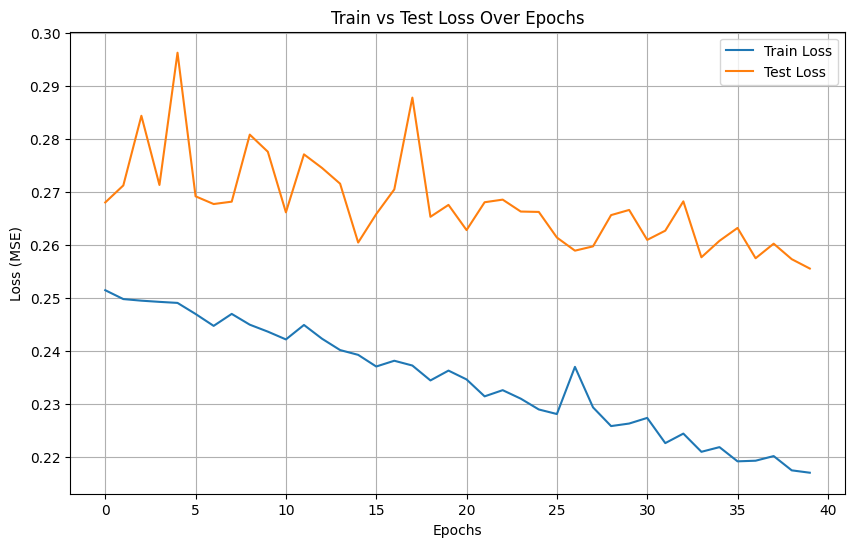

In [266]:
# Function to train the model and collect loss values for plotting
def train_regression_with_curves(train_loader, test_loader, model, criterion, optimizer, epochs=40):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Average loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on the test set after each epoch
        test_loss = evaluate_regression(test_loader, model)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

# Evaluate the model on the test set
def evaluate_regression(test_loader, model):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()
    return test_loss / len(test_loader)

# Train the model and collect train/test losses
train_losses, test_losses = train_regression_with_curves(train_loader, test_loader, pytorch_model, criterion, optimizer, epochs=40)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Train vs Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()